# Work in progress (WIP)

# 4. Deutsch's algorithm

In this lesson you will learn:
- **Query algorithms**
- Deutsch's algorithm, which provides a clear quantum advantage on recognizing parity of a function.
- Deutsch-Josza algorithm, which generalizes Deutsch's algorithm more than 2 qubits.
- BONUS: Bernstein-Vazirani algorithm

In [1]:
# Specific install for Kaggle Notebooks environment
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

# Kaleido is used to convert Plotly to static png
!pip install -Uqq kaleido
!pip install -Uqq skq

In [2]:
import numpy as np
from skq.gates.qubit import H, Measure, DeutschJozsaOracle
from skq.circuits import Concat, Circuit

# Fix Plotly rendering in Jupyter forks.
# If you are running this notebook locally you can comment this out.
# This allows you to play with interactive Plotly plots.
import plotly.io as pio
pio.renderers.default = 'png'

Deutsch's algorithm is an essential algorithm to understand advantages of quantum computing. It leverages **superposition** and **interference** to evaluate if a function is constant or balanced in one pass. Classical algorithms require multiple passes to determine this. This is achieved through a phenomenon called **phase kickback**. Deutsch's algorithm is the simplest case that can be implemented with 1 qubit and evaluate a binary function ($f: \{0,1\} \rightarrow \{0,1\}$). The Deutsch-Josza algorithm generalizes this to multiple qubits ($f: \{0,1\}^n \rightarrow \{0,1\}$).

Deutsch's algorithm is an example of **query algorithms**. These are algorithms where a **black box** function $f$ is integrated in the quantum circuit and used to evaluate that function. We will see this query model in many quantum algorithms with quantum advantage, like **Grover's algorithm** and **Shor's algorithm**.



## Deutsch's algorithm

Deutsch's algorithm is take in a binary function $f$ and determine if it is constant or balanced.

Constant means that the function always return the same values, for the binary input $0$ and $1$ this means that $f(0) = f(1)$. A different way to think about this is that $f(x) = 0$ or $f(x) = 1$ for all $x$.

Balanced means that different inputs give different values with a 50/50 distribution. For the binary input $0$ and $1$ this means that $f(0) \neq f(1)$. Examples of balanced functions are a bit flip or the identity function.

The function $f$ is integrated in the quantum circuit. Around $f$ we place $H$ gates to put the qubit in superposition and get quantum interference effects. The `DeutschJozsaOracle` from `skq` works for $n$ qubits so we can also use it for Deutsch's algorithm with $n=1$.


In [3]:
def deutsch_circuit(f) -> Circuit:
    """ 
    Deutsch's algorithm
    :param f: Binary function that maps a single bit to a single bit.
    :return: skq Circuit that implements Deutsch's algorithm.
    """
    return Circuit([
        H(),
        DeutschJozsaOracle(f, n_bits=1),
        H(),
        Measure()
    ])

def deutsch_balanced_func(x):
        """f(0)=0, f(1)=1"""
        return x

def deutsch_constant_func(x):
        """Always 0: f(0)=0, f(1)=0"""
        return 0

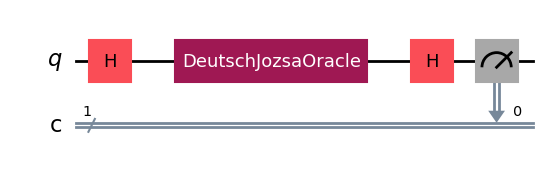

In [4]:
deutsch_balanced_circuit = deutsch_circuit(deutsch_balanced_func)
deutsch_balanced_circuit.draw(output='mpl')

`DeutschJozsaOracle` represents a balanced function. For this oracle we expect to see a **phase kickback** effect, where the qubit is flipped. By starting the circuit in the state $|0\rangle$ we expect to see a $|1\rangle$ result.

In [5]:
deutsch_balanced_circuit[1]

DeutschJozsaOracle([[ 1.+0.j,  0.+0.j],
                    [ 0.+0.j, -1.+0.j]])

Note that the oracle for a balanced function in Deutsch's algorithm here is the same as the $Z$ gate, which is also called a **phase flip**.

In [6]:
deutsch_balanced_circuit([1, 0]).round(3)

array([0., 1.])

Our result is $|1\rangle$ so we can conclude that the function is balanced with one pass. Note that we didn't need entanglement to determine this. 

A classical algorithm would require two passes, because it would need to verify both input $0$ and $1$ to determine if the function is balanced. This is a clear demonstration of quantum advantage even if the use cases of Deutsch's algorithm are limited. We will see later that this phenomenon of phase kickback can become powerful as it is used in **Shor's algorithm** to break encryption by factoring large numbers.

For constant functions `DeutschJozsaOracle` represents an identity gate ($I$). So if our input is $|0\rangle$ we expect to see $|0\rangle$ as result. On the surface the circuit looks the same as the balanced function circuit, but the oracle is now structured differently.

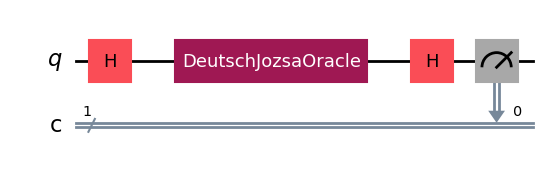

In [7]:
deutsch_constant_circuit = deutsch_circuit(deutsch_constant_func)
deutsch_constant_circuit.draw(output='mpl')

In [8]:
# Deutsch Oracle for constant function is the same as the identity gate I.
deutsch_constant_circuit[1]

DeutschJozsaOracle([[1.+0.j, 0.+0.j],
                    [0.+0.j, 1.+0.j]])

In [9]:
deutsch_constant_circuit([1, 0]).round(3)

array([1., 0.])

The result is $|0⟩$, so we can conclude that the function is constant. 

Note that we don't need to know the function $f$ to determine if it is constant or balanced. We only need to have the ability to query the oracle in our circuit. A classical analogy would be having access to an API somewhere on the Internet. We can query the API with different inputs and evaluate the output.

Still you might be curious how the oracle is structured. For this demonstration we prepare the oracle by looping over inputs and compute $(-1)^{f(x)}$ for each input $x$. Let's look at how the oracle is prepared for the balanced function.

In [10]:
# Start with identity matrix
oracle_matrix = np.eye(2)
# Loop over inputs and compute (-1)^{f(x)}
for x in range(2):
    oracle_matrix[x, x] = (-1) ** deutsch_balanced_func(x)
# Oracle for balanced function -> Z (phase flip) gate
oracle_matrix

array([[ 1.,  0.],
       [ 0., -1.]])

This process generalizes to any number of qubits. When we apply this phase kickback effect for multiple qubits it is called a **Deutsch-Jozsa** algorithm.

## Deutsch-Josza algorithm

The **Deutsch-Josza algorithm** is very similar to Deutsch's algorithm. Again we apply $H$ gates on every qubit before and after the oracle to get a quantum superposition and leverage interference effects. Note that as we generalize to function with multiple qubits it becomes possible to encounter function that are neither constant nor balanced. For example where 25% of the inputs return $0$ and 75% return $1$. For this algorithm to work we need to make sure that our function $f$ is either constant or balanced, else the algorithm will give unpredictable results. This necessity is called the **promise**. **Deutsch-Josza** is therefore a **promise problem**. In code this **promise** is achieved with an `assert` statement.

Here is the formal definition of a balanced and constant function for **Deutsch-Josza** on $n$ qubits:

- Balanced function: $f(x_1, \ldots, x_n) = 1$ for exactly $2^{n-1}$ inputs and $f(x_1, \ldots, x_n) = 0$ for the remaining $2^{n-1}$ inputs.
- Constant function: $f(x_1, \ldots, x_n) = 0$ for all inputs or $f(x_1, \ldots, x_n) = 1$ for all inputs.

Here the quantum advantage becomes more clear compared to Deutsch's algorithm. A deterministic classical algorithm requires $2^{n-1} + 1$ queries to determine if the function is constant or balanced. A probabilistic classical algorithm still requires a few queries. The Deutsch-Josza algorithm requires only $1$ query.

1. Choose $k$ input strings $x_1, \ldots, x_k$ at random.
2. If $f(x_i) = 1$ for all $i = 1, \ldots, k$, then output constant, else balanced. If $f$ is constant algorithm is 100% correct. if $f$ is balanced, the algorithm is correct with probability $1 - 2^{-k+1}$.



In [11]:
def deutsch_josza_circuit(f, n_bits: int) -> Circuit:
    """
    Deutsch-Josza algorithm
    :param f: Binary function that maps a single bit to a single bit.
    :return: skq Circuit that implements Deutsch-Josza algorithm.
    """
    return Circuit([
        Concat([H() for _ in range(n_bits)]),
        DeutschJozsaOracle(f, n_bits=n_bits),
        Concat([H() for _ in range(n_bits)]),
        Measure()
    ])

def deutsch_josza_balanced_function(x):
    """Balanced function: f(0)=0, f(1)=0, f(2)=1, f(3)=1, 
                          f(4)=0, f(5)=0, f(6)=1, f(7)=1,
                          f(8)=0, f(9)=0, f(10)=1, f(11)=1,
                          f(12)=0, f(13)=0, f(14)=1, f(15)=1"""
    return 1 if x >= 8 else 0  # Half of the states are 1

def deutsch_josza_constant_function(x):
    """Always 0: f(x) = 0 for all x"""
    return 0  # Always 0

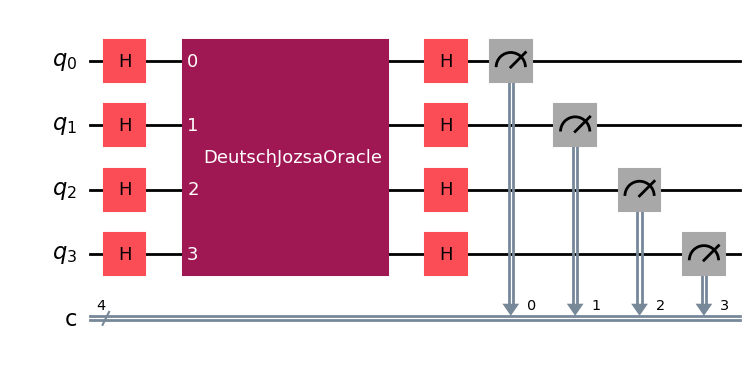

In [12]:
n_qubits = 4
balanced_circuit = deutsch_josza_circuit(deutsch_josza_balanced_function, n_qubits)
balanced_circuit.draw(output='mpl')

If the function is balanced the oracle will represent a $CCCZ$ gate, a controlled Z gate with $3$ control qubits and $1$ target qubit, so the qubits are entangled in the oracle. Apart from this the structure of the Deutsch and Deutsch-Josza algorithms are the same. Even though we work with multiple qubits and measure them, we only need to look at the first qubit to determine if the function is constant or balanced. For 4 qubits the balanced function should give a result of $|1000⟩$ and a constant function $|0000⟩$.

In query algorithms like Deutsch-Josza we always initialize the qubits in the zero state. For 4 qubits this is $|0000⟩$.

In [13]:
four_qubit_zero_state = [1] + [0]*(2**n_qubits-1)

In [14]:
balanced_circuit(four_qubit_zero_state).round(3)

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

The resulting statevector represents $|1000⟩$. The first qubit is $1$, so the function is balanced. 

For the constant function the output should be $|0000⟩$.

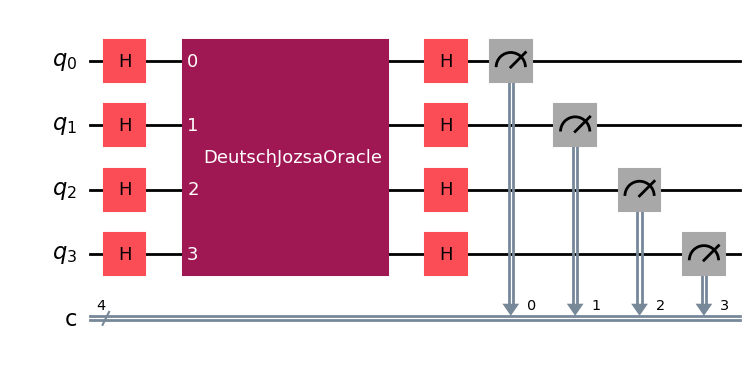

In [15]:
constant_circuit = deutsch_josza_circuit(deutsch_josza_constant_function, n_qubits)
constant_circuit.draw(output='mpl')

In [16]:
constant_circuit(four_qubit_zero_state).round(3)

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

The resulting statevector represents $|0000⟩$. The first qubit is $0$, so the function is constant.

Don't worry if the idea of an oracle still sounds a bit abstract. In this notebook we focused on understanding and analyzing the algorithms so we have demonstrated how to simulate an oracle on a classical computer. Research on these algorithms often implies that the oracle is a quantum state that acts as a black box. Over time you will become more comfortable with the query algorithm model and discover why it is powerful to develop quantum algorithms in this way. 

Next we will apply the query model to achieve a quadratic speedup in unstructured search problems. This algorithm is called **Grover's algorithm**. Later we will discover how to achieve near exponential speedups to break encryption by factoring large numbers through **Shor's algorithm**.

# BONUS: Bernstein-Vazirani

- The same Deutsch-Josza algorithm can also solve the **Bernstein-Vazirani** problem. A recursive version of Bernstein-Vazirani was one of the first algorithms that gain a superpolynomial advantage over classical algorithms.

- In essence the same circuit as Deutsch-Josza.

- Difference: Oracle encodes bitstring $s$, instead of a function $f$.



# Work In Progress (WIP)